In [1]:
import imp
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D, InputLayer, LeakyReLU
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import glob 
import csv
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split


C:\Users\sagor\AppData\Local\Temp\ipykernel_13328\2297277722.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
def gen_label(directory):
    label = []
    for dir in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dir)):
            if (dir == 'Cancer'):
                label.append(str(0))
            elif (dir == 'Healthy'):
                label.append(str(1))
    return label

def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [3]:
train_y = gen_label('./Gaussian/train')
train_x = get_path('./Gaussian/train')

In [4]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df)


                                   filename category
0             Cancer/gaussianCancer (1).jpg        0
1             Cancer/gaussianCancer (1).tif        0
2            Cancer/gaussianCancer (10).jpg        0
3           Cancer/gaussianCancer (100).jpg        0
4          Cancer/gaussianCancer (1002).JPG        0
...                                     ...      ...
3664  Healthy/gaussianNot Cancer  (995).jpg        1
3665  Healthy/gaussianNot Cancer  (996).jpg        1
3666  Healthy/gaussianNot Cancer  (997).jpg        1
3667  Healthy/gaussianNot Cancer  (998).jpg        1
3668  Healthy/gaussianNot Cancer  (999).jpg        1

[3669 rows x 2 columns]


In [5]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(2751, 2)
(918, 2)


In [6]:
image_data = ImageDataGenerator(rescale=1./255,
                                validation_split = 0.2,
                                zoom_range=(0.99,0.99))

def preprocessingTrain(path):
    image = image_data.flow_from_directory(directory=path, 
                                           target_size=(224,224), 
                                           batch_size=8, 
                                           seed=123,
                                           subset='training',)
    return image

In [7]:
def preprocessingVal(path):
    
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           )
    return image

In [8]:
def preprocessingTest(path):
    
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           )
    
    return image

In [9]:
path = './Gaussian/train'
train_data = preprocessingTrain(path)

Found 2936 images belonging to 2 classes.


In [10]:
path = './Gaussian/val'
val_data= preprocessingVal(path)

Found 909 images belonging to 2 classes.


In [11]:
path = './Gaussian/test'
test_data = preprocessingTest(path)

Found 909 images belonging to 2 classes.


In [12]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
# Early stopping and model checkpoint
from keras import utils, callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_loss", 
                                        mode="min", 
                                        patience=5, 
                                        restore_best_weights = True)

In [16]:
# model = Sequential()
history = model.fit_generator(train_data,
                              verbose=1,
                              callbacks = [earlystopping],
                              epochs=30,
                              validation_data=(val_data))

c:\Users\sagor\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
367/367 [==============================] - 52s 123ms/step - loss: 0.2586 - accuracy: 0.8992 - val_loss: 0.1643 - val_accuracy: 0.9362
Epoch 2/30
367/367 [==============================] - 44s 119ms/step - loss: 0.1439 - accuracy: 0.9465 - val_loss: 0.1034 - val_accuracy: 0.9659
Epoch 3/30
367/367 [==============================] - 44s 119ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.1352 - val_accuracy: 0.9505
Epoch 4/30
367/367 [==============================] - 44s 119ms/step - loss: 0.1008 - accuracy: 0.9605 - val_loss: 0.0969 - val_accuracy: 0.9725
Epoch 5/30
367/367 [==============================] - 44s 119ms/step - loss: 0.0448 - accuracy: 0.9823 - val_loss: 0.0753 - val_accuracy: 0.9758
Epoch 6/30
367/367 [==============================] - 45s 122ms/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.0499 - val_accuracy: 0.9868
Epoch 7/30
367/367 [==============================] - 43s 117ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0559 - val_ac

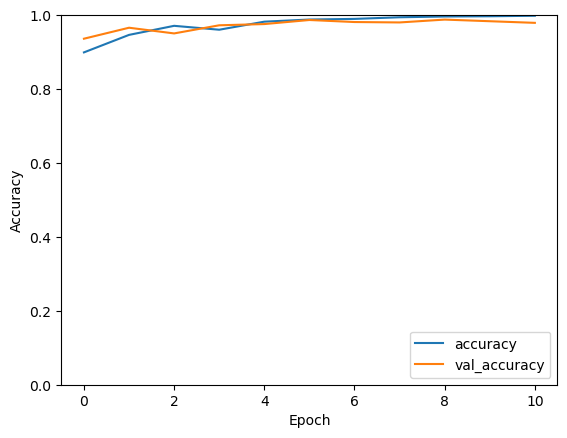

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


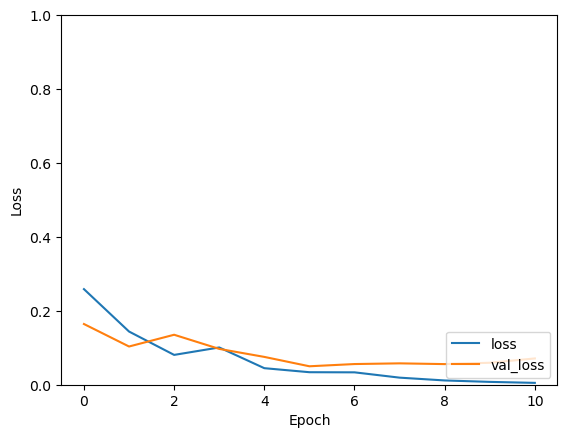

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [19]:
model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [21]:
feature_list = []
for path in train_df['filename'].to_numpy():
    full_path = './Gaussian/train/'+ path
    x = load_img(full_path,target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)
    feature_list.append(features)
    
# feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [22]:
feat_lst = np.reshape(feature_list,(-1,1024))

In [23]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# features = tarnsfer_model.predict(test_data)
# y  = test_label.astype('int')
y = train_df['category'].to_numpy()
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(feat_lst,
                                                                            y,
                                                                            test_size = 0.20,
                                                                            random_state = 2020)

In [24]:
import csv

# Assuming `features` is a numpy array
import numpy as np

# Define the image names
img_names = [y[i] for i in range(feat_lst.shape[0])]

# Write the features to a CSV file with column names and image names
with open('features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Label'] + list(range(1, feat_lst.shape[1]+1)))
    for i, row in enumerate(feat_lst):
        writer.writerow([img_names[i]] + list(row))

# Read the features from the CSV file
with open('features.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader) # Skip the first row (headers)
    img_names = [row[0] for row in reader] # Extract the image names
    feat_lst = np.array([row[1:] for row in reader]).astype(float) # Extract the features


RANDOM FOREST

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=4020)

#train classifier
rf_classifier.fit(train_features, train_labels)

# Make predictions on the test data
test_predictions = rf_classifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test accuracy: ", test_accuracy)

Test accuracy:  0.911070780399274


Precision for Brain Tumor

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='0')
recall = recall_score(test_labels, test_predictions, pos_label='0')
f1 = f1_score(test_labels, test_predictions, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9180887372013652
Recall:  0.9149659863945578
F1-score:  0.9165247018739353


Precision for Healthy

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='1')
recall = recall_score(test_labels, test_predictions, pos_label='1')
f1 = f1_score(test_labels, test_predictions, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9031007751937985
Recall:  0.9066147859922179
F1-score:  0.9048543689320389


KNN

In [28]:
#Fitting K-NN classifier to the training set  
from sklearn.neighbors import KNeighborsClassifier  
knnClassifier= KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2)  
knnClassifier.fit(train_features, train_labels)  

# Make predictions on the test data
test_predictions_knn = knnClassifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy_knn = accuracy_score(test_labels, test_predictions_knn)

print("Test accuracy: ", test_accuracy_knn)

Test accuracy:  0.9328493647912885


Brain Tumor

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='0')
recall = recall_score(test_labels, test_predictions_knn, pos_label='0')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9269102990033222
Recall:  0.9489795918367347
F1-score:  0.9378151260504202


Healthy

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='1')
recall = recall_score(test_labels, test_predictions_knn, pos_label='1')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.94
Recall:  0.914396887159533
F1-score:  0.9270216962524656


ADA Boost

In [31]:
from sklearn.ensemble import AdaBoostClassifier
ab_classifier = AdaBoostClassifier(n_estimators=10, random_state=2020)
ab_classifier.fit(train_features, train_labels)
test_predictions_ab = ab_classifier.predict(test_features)
test_accuracy_ab = accuracy_score(test_labels, test_predictions_ab)

print("Test accuracy: ", test_accuracy_ab)

Test accuracy:  0.7695099818511797


Brain Tumor

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='0')
recall = recall_score(test_labels, test_predictions_ab, pos_label='0')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.7849829351535836
Recall:  0.782312925170068
F1-score:  0.7836456558773425


Healthy

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='1')
recall = recall_score(test_labels, test_predictions_ab, pos_label='1')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.751937984496124
Recall:  0.754863813229572
F1-score:  0.7533980582524271


In [34]:
def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [35]:
test_x = get_path('./Gaussian/test/')

In [36]:
# define function for evaluating model performance on test images
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img

testdf = pd.DataFrame({'filename': test_x})
test_sample = testdf.sample(n = 20, random_state=2020)

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = './Gaussian/test/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'random_forest':
            features = model.predict(img_array)
            result = rf_classifier.predict(features)
        elif name == 'knn':
            features = model.predict(img_array)
            result = knnClassifier.predict(features)
        elif name == 'adaboost':
            features = model.predict(img_array)
            result = ab_classifier.predict(features)
        result = 'Healthy' if float(result) > 0.5 else 'Brain Tumor'
        
        result_lst.append(result)
    return result_lst

In [37]:

rf_result = test_img(model,'random_forest')
ada_result = test_img(model,'adaboost')
knn_result = test_img(model,'knn')

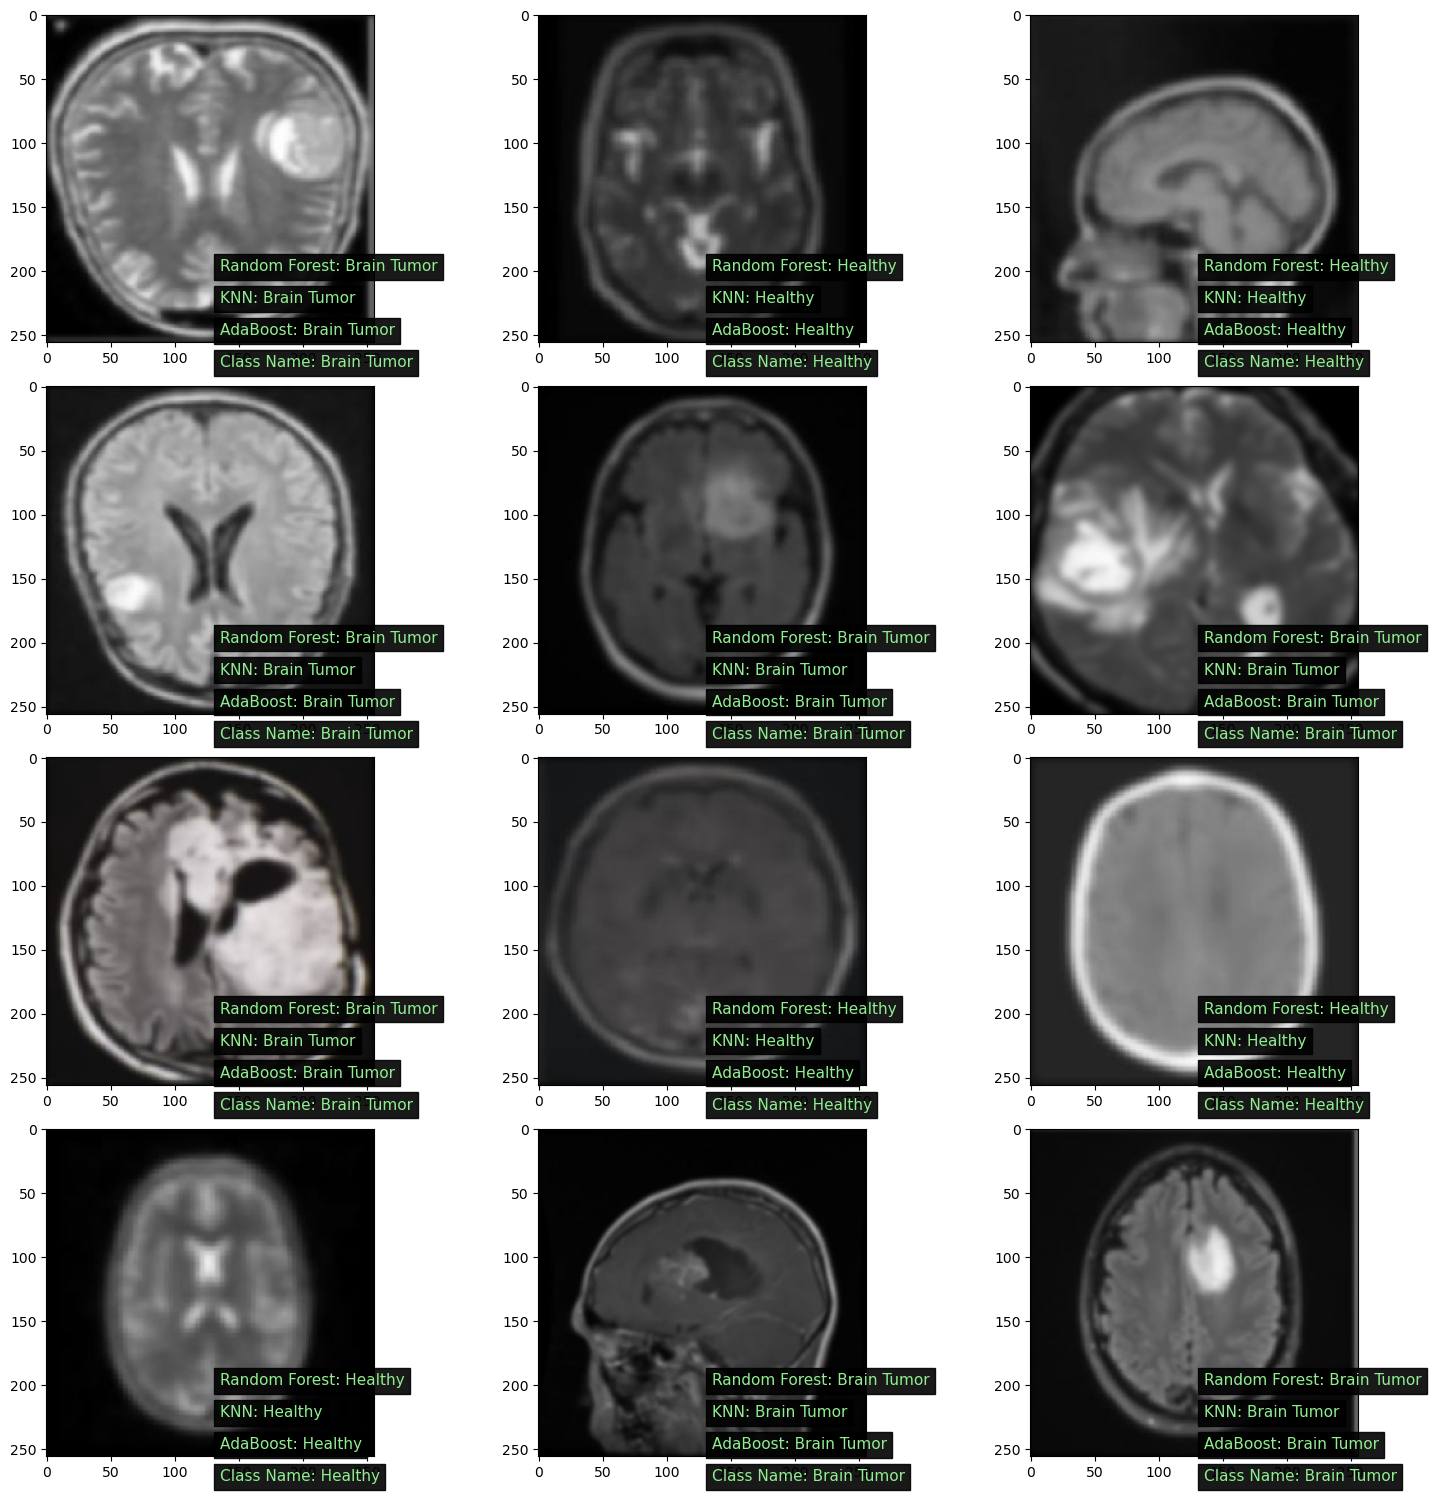

In [38]:
# plotting images with prediction
pred_results  = list(zip(rf_result,knn_result, ada_result))
test_array = test_sample['filename'].to_numpy()

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    rf, knn, ab= pred_results[i]
    img = test_array[i]
    path = './Gaussian/test/' + img
    name = img.split('/')[0]
    if(name == 'Cancer'):
        name = 'Brain Tumor'
    image = load_img(path, target_size=(256,256))
    # plt.text(135, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 200, 'Random Forest: {}'.format(rf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 225, 'KNN: {}'.format(knn), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 250, 'AdaBoost: {}'.format(ab), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 275, 'Class Name: {}'.format(name), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    
    plt.imshow(image)

plt.tight_layout()
plt.show()